# 実践課題：画像コントラスト変換
1. 課題概要
画像コントラスト変換とは、入力画像の輝度やコントラストを調整し、視覚的な特徴を強調または変更するタスクです。この課題では以下を目標とします：

- コントラストを強調した画像を生成する。
- モデルを構築し、指定されたコントラスト値に応じて画像を変換する。

### ステップ1: データセットの準備
任意の画像データセット（CIFAR10など）を利用し、コントラストを変更します。以下は、torchvision.transforms を利用した例です。

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


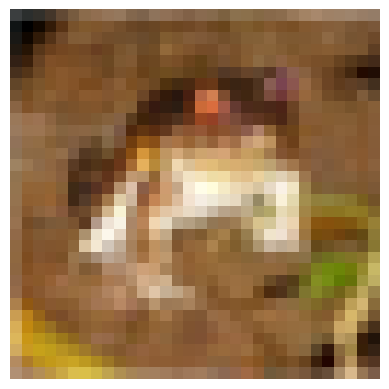

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# データ変換（Tensor化）
transform = transforms.Compose([
    transforms.ToTensor()
])

# CIFAR10データセットのロード
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# サンプル画像の可視化
def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0)  # チャンネル順を変換
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# サンプル画像
sample_img, _ = dataset[0]
show_image(sample_img)


### ステップ2: コントラスト変更関数
以下は、画像のコントラストを変更する関数の例です。

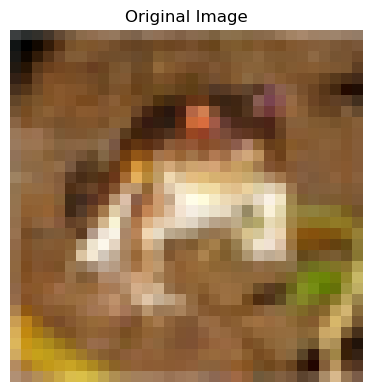

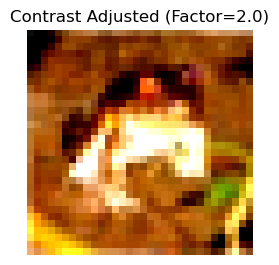

In [2]:
from torchvision.transforms.functional import adjust_contrast

# コントラスト変更
contrast_factor = 2.0  # コントラストの強さ
adjusted_img = adjust_contrast(sample_img, contrast_factor)

# 元画像と変換後の画像を比較
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
show_image(sample_img)

plt.subplot(1, 2, 2)
plt.title(f"Contrast Adjusted (Factor={contrast_factor})")
show_image(adjusted_img)


### ステップ3: モデルの構築
畳み込みニューラルネットワーク（CNN）を使用して、コントラスト変換を学習します。入力は元画像、出力はコントラストを調整した画像です。

In [3]:
import torch.nn as nn

class ContrastAdjustmentNet(nn.Module):
    def __init__(self):
        super(ContrastAdjustmentNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ContrastAdjustmentNet()


### ステップ4: トレーニング
ノイズ付き画像を入力し、正解のコントラスト変換画像を出力するように学習します。

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import adjust_contrast

# データ変換（Tensor化）
transform = transforms.Compose([
    transforms.ToTensor()
])

# CIFAR10データセットのロード
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# データローダーの準備
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# モデル定義
class ContrastAdjustmentNet(nn.Module):
    def __init__(self):
        super(ContrastAdjustmentNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # [3x32x32] -> [64x16x16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [64x16x16] -> [128x8x8]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [128x8x8] -> [64x16x16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64x16x16] -> [3x32x32]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ContrastAdjustmentNet()

# 損失関数と最適化
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングループ
num_epochs = 5
contrast_factor = 2.0  # コントラストの変更係数

for epoch in range(num_epochs):
    for images, _ in train_loader:
        # コントラスト変更後の画像を生成（ターゲット）
        target_images = torch.stack([adjust_contrast(img, contrast_factor) for img in images], dim=0)

        # モデルの出力
        outputs = model(images)

        # 出力サイズとターゲットサイズを確認
        # print(f"Output shape: {outputs.shape}, Target shape: {target_images.shape}")

        # 損失計算とバックプロパゲーション
        loss = criterion(outputs, target_images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Files already downloaded and verified
Epoch [1/5], Loss: 0.0071
Epoch [2/5], Loss: 0.0078
Epoch [3/5], Loss: 0.0052
Epoch [4/5], Loss: 0.0057
Epoch [5/5], Loss: 0.0055


### ステップ5: テスト
学習したモデルで画像のコントラストを変更し、結果を可視化します。

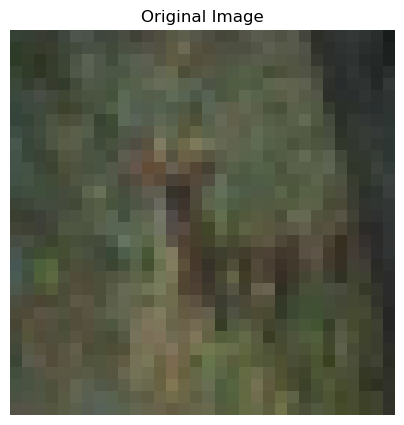

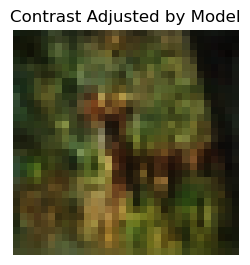

In [8]:
with torch.no_grad():
    test_img, _ = dataset[10]
    test_img = test_img.unsqueeze(0)  # バッチ次元を追加
    adjusted_output = model(test_img)

# 可視化
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
show_image(test_img.squeeze())

plt.subplot(1, 2, 2)
plt.title("Contrast Adjusted by Model")
show_image(adjusted_output.squeeze())


### 課題のポイント
1. コントラスト係数の変化:
- contrast_factor を変更して性能の違いを観察。
2. モデルの改良:
- 畳み込み層やプーリング層を増やす。
- 損失関数を変更して違いを確認。
3. その他の変換:
- 明るさや彩度の調整も同時に学習させる。